<a href="https://colab.research.google.com/github/123shwetarohokale/lammps-aluminum-optimization/blob/main/analyze_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!git clone https://github.com/123shwetarohokale/lammps-aluminum-optimization.git
%cd lammps-aluminum-optimization

Cloning into 'lammps-aluminum-optimization'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 112 (delta 56), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 5.11 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/lammps-aluminum-optimization/lammps-aluminum-optimization/lammps-aluminum-optimization


In [16]:
import os
print(os.getcwd())
print(os.listdir())

/content/lammps-aluminum-optimization/lammps-aluminum-optimization/lammps-aluminum-optimization
['energy_convergence.log', 'timing_energy_lat4.log', '.git', 'gitignore (1).txt', 'submitenergycon-job.sh', 'Al99.eam (3).alloy', 'al.data-lattice.out', 'README.md', 'log.lammps', 'in_lattice_eng.nvt', 'energy_time_series.dat', 'al.o1856655', 'al.dat.out', 'Copy_of_analyze_energy.ipynb', 'submit-job.sh', 'submitlattice-job.sh', 'in.nvt', 'Al99.eam.alloy', '.gitignore.txt', 'in_lattice.nvt', 'in_autocorrelation.nvt', 'analyze_energy.ipynb']


Reached end of Atoms section.
‚úÖ Total atoms read: 62500


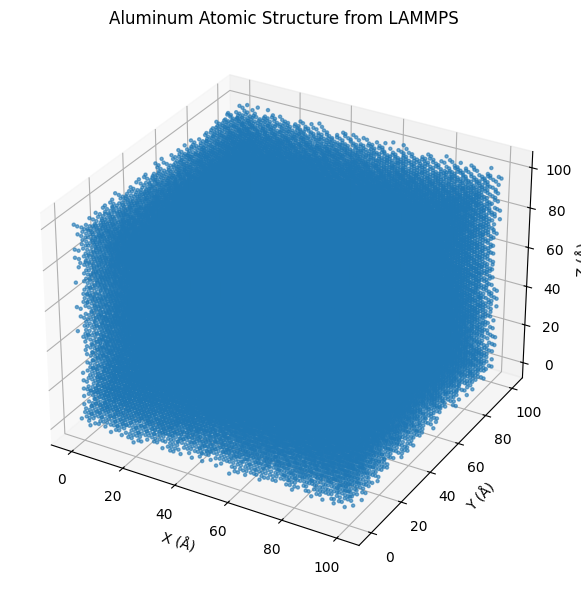

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

positions = []
reading_atoms = False
atom_section_started = False

# ‚úÖ Use correct file name
with open("al.data-lattice.out") as file:
    for line in file:
        if "Atoms # atomic" in line:
            reading_atoms = True
            continue
        if reading_atoms:
            # Skip blank lines after header
            if not atom_section_started:
                if line.strip() == "":
                    continue
                else:
                    atom_section_started = True  # Start reading actual data

            # Stop at the next section or unexpected line
            if line.strip() == "" or line[0].isalpha():
                print("Reached end of Atoms section.")
                break

            parts = line.strip().split()
            if len(parts) >= 5:
                try:
                    x, y, z = float(parts[2]), float(parts[3]), float(parts[4])
                    positions.append([x, y, z])
                except ValueError:
                    print("Line skipped (bad float):", line.strip())
            else:
                print("Line skipped (too few columns):", line.strip())

positions = np.array(positions)
print(f"‚úÖ Total atoms read: {len(positions)}")

# Plot if data is valid
if positions.ndim == 2 and positions.shape[1] == 3:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=5, alpha=0.6)

    ax.set_xlabel('X (√Ö)')
    ax.set_ylabel('Y (√Ö)')
    ax.set_zlabel('Z (√Ö)')
    ax.set_title('Aluminum Atomic Structure from LAMMPS')

    plt.tight_layout()
    plt.show()
else:
    print("‚ùå Error: No valid atomic coordinates found.")


‚ö†Ô∏è Invalid value in line: print "Cohesive energy (eV) = ${ecoh};"
‚úÖ Found cohesive energy: -3.36000 eV at a = 4.00 √Ö


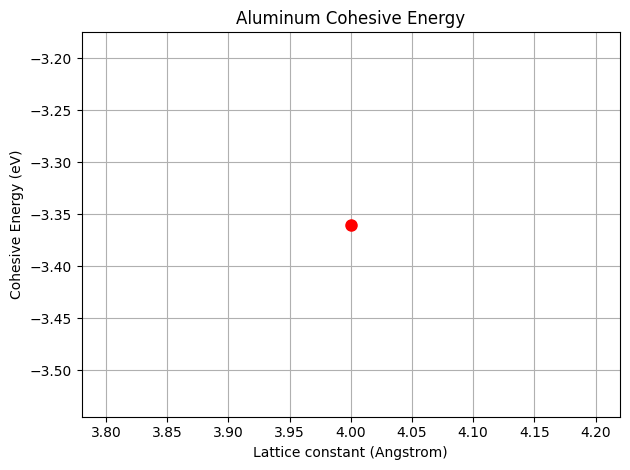

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define lattice constant and corresponding log file
latconst = 4.00
log_file = "log.lammps"

# Initialize variable to store cohesive energy
ecoh = None

# Open and parse the LAMMPS log file
with open(log_file, "r") as f:
    for line in f:
        if "Cohesive energy (eV)" in line:
            parts = line.strip().split("=")
            if len(parts) == 2:
                try:
                    # Clean up the line and convert to float
                    ecoh = float(parts[1].strip().replace(";", "").replace('"', '').replace("'", ''))
                    break
                except ValueError:
                    print(f"‚ö†Ô∏è Invalid value in line: {line.strip()}")
                    ecoh = None

# Print and handle result
if ecoh is None:
    print(f"‚ùå Cohesive energy not found or invalid in {log_file}")
    ecoh = np.nan
else:
    print(f"‚úÖ Found cohesive energy: {ecoh:.5f} eV at a = {latconst:.2f} √Ö")

# Plotting (even if it's just one point)
plt.figure()
plt.plot([latconst], [ecoh], 'ro', markersize=8)
plt.xlabel('Lattice constant (Angstrom)')
plt.ylabel('Cohesive Energy (eV)')
plt.title('Aluminum Cohesive Energy')
plt.grid(True)
plt.tight_layout()
plt.savefig("cohesive_energy_single_point.png", dpi=300)
plt.show()



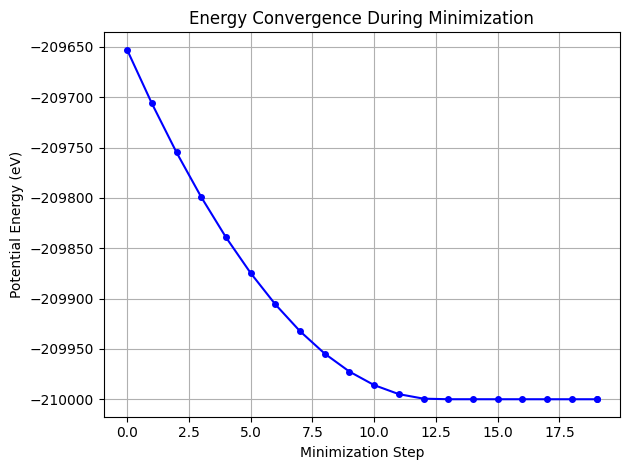

In [ ]:
import matplotlib.pyplot as plt

steps = []
energies = []

with open("energy_convergence.log", "r") as f:
    for line in f:
        if line.strip().startswith("Step") or line.startswith("Loop"):
            continue
        tokens = line.strip().split()
        if len(tokens) >= 2:
            try:
                steps.append(int(tokens[0]))
                energies.append(float(tokens[1]))  # PE
            except ValueError:
                continue

plt.figure()
plt.plot(steps, energies, 'b-o', markersize=4)
plt.xlabel("Minimization Step")
plt.ylabel("Potential Energy (eV)")
plt.title("Energy Convergence During Minimization")
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_convergence.png", dpi=300)
plt.show()

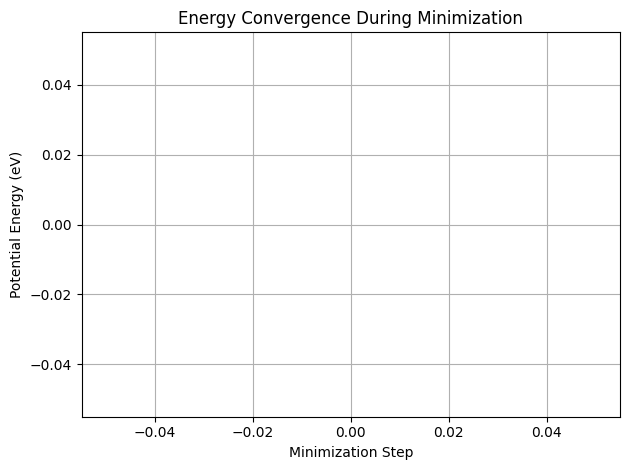

‚úÖ Loop time: 0.584 seconds for 10000 steps
üïí Time per timestep: 0.000058 seconds


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import re

log_file = "timing_energy_lat4.log"  # Adjust for your actual lattice constant
timesteps_run = 10000  # Must match the number in your LAMMPS input

# ---------- Part 1: Extract energy convergence ----------
steps = []
energies = []

with open(log_file, "r") as f:
    reading_thermo = False
    for line in f:
        if line.startswith("Step"):
            reading_thermo = True
            continue
        if reading_thermo:
            if line.strip() == "" or "Loop time" in line:
                reading_thermo = False
                continue
            tokens = line.strip().split()
            if len(tokens) >= 2:
                try:
                    step = int(tokens[0])
                    pe = float(tokens[1])
                    steps.append(step)
                    energies.append(pe)
                except ValueError:
                    continue

# Plot energy convergence
plt.figure()
plt.plot(steps, energies, 'b-o', markersize=4)
plt.xlabel("Minimization Step")
plt.ylabel("Potential Energy (eV)")
plt.title("Energy Convergence During Minimization")
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_convergence.png", dpi=300)
plt.show()

# ---------- Part 2: Extract computational time per timestep ----------
loop_time = None

with open(log_file, "r") as f:
    for line in f:
        if "Loop time of" in line and "on" in line:
            match = re.search(r"Loop time of\s+([0-9.]+)", line)
            if match:
                loop_time = float(match.group(1))
                break

if loop_time is not None:
    time_per_step = loop_time / timesteps_run
    print(f"‚úÖ Loop time: {loop_time:.3f} seconds for {timesteps_run} steps")
    print(f"üïí Time per timestep: {time_per_step:.6f} seconds")
else:
    print("‚ùå Could not find 'Loop time' in log file.")


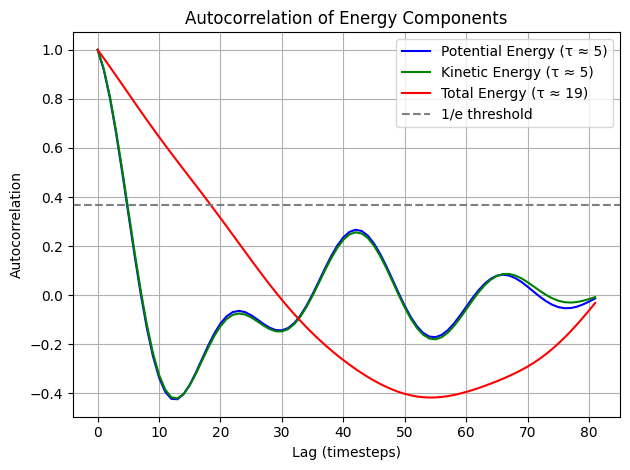


 Estimated Number of Independent Samples with Time Info:

Component            Total_Steps    dt (fs) œÑ(steps)     œÑ (fs)     Indep. Samples
--------------------------------------------------------------------------
Potential Energy           82       2.50        5      12.50                  8
Kinetic Energy             82       2.50        5      12.50                  8
Total Energy               82       2.50       19      47.50                  2


In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Load energy time series (assumes columns: PE, KE, TE)
data = np.loadtxt("energy_time_series.dat")
pe, ke, te = data[:, 0], data[:, 1], data[:, 2]

# User-specified MD parameters
timestep_fs = 2.5  # fs per timestep (match your LAMMPS input)
total_steps = len(pe)

# Define autocorrelation
def autocorr(x):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size // 2:]
    return result / result[0]

def estimate_tau(acf):
    for i, val in enumerate(acf):
        if val < 1 / np.e:
            return i
    return len(acf)

# Prepare metadata
labels = ['Potential Energy', 'Kinetic Energy', 'Total Energy']
colors = ['b', 'g', 'r']
series = [pe, ke, te]

# Plot autocorrelations
plt.figure()
taus = []
for i, s in enumerate(series):
    ac = autocorr(s)
    tau = estimate_tau(ac)
    taus.append(tau)
    plt.plot(ac[:200], label=f"{labels[i]} (œÑ ‚âà {tau})", color=colors[i])

plt.axhline(1 / np.e, color='gray', linestyle='--', label='1/e threshold')
plt.xlabel('Lag (timesteps)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Energy Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("autocorr_all_energies.png", dpi=300)
plt.show()

# Print summary table
print("\n Estimated Number of Independent Samples with Time Info:\n")
print(f"{'Component':20} {'Total_Steps':>8} {'dt (fs)':>10} {'œÑ(steps)':>8} {'œÑ (fs)':>10} {'Indep. Samples':>18}")
print("-" * 74)

for i, tau in enumerate(taus):
    tau_fs = tau * timestep_fs
    n_indep = int(total_steps / (2 * tau)) if tau > 0 else total_steps
    print(f"{labels[i]:20} {total_steps:>8} {timestep_fs:>10.2f} {tau:>8} {tau_fs:>10.2f} {n_indep:>18}")

‚úÖ Autocorrelation time for Potential Energy: œÑ ‚âà 5 timesteps
‚úÖ Autocorrelation time for Kinetic Energy: œÑ ‚âà 5 timesteps
‚úÖ Autocorrelation time for Total Energy: œÑ ‚âà 11 timesteps


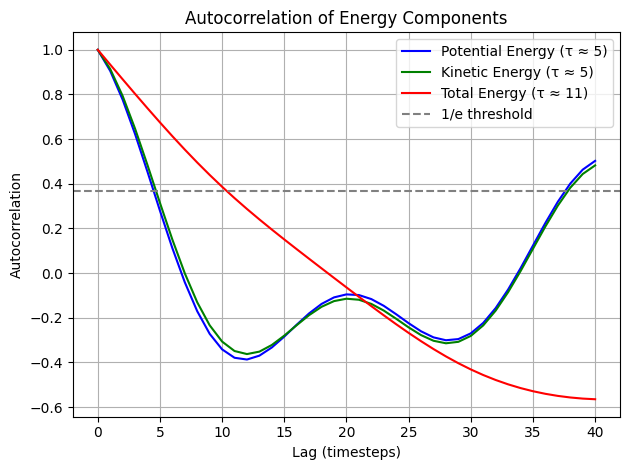


üìä Estimated Number of Independent Samples with Time Info:

Component            Steps      dt (fs)    œÑ (steps)    œÑ (fs)     Indep. Samples    
--------------------------------------------------------------------------------
Potential Energy     82         2.5        5            12.50      8                 
Kinetic Energy       82         2.5        5            12.50      8                 
Total Energy         82         2.5        11           27.50      3                 


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Autocorrelation Function ----------
def autocorr1D(array):
    """Fast FFT-based normalized autocorrelation function."""
    ft = np.fft.rfft(array - np.mean(array))
    acorr = np.fft.irfft(ft * np.conj(ft)) / (len(array) * np.var(array))
    return acorr[:len(acorr) // 2]

def estimate_tau(acorr):
    """Estimate autocorrelation time as first index where ACF < 1/e."""
    try:
        return np.where(acorr < 1/np.e)[0][0]
    except IndexError:
        return len(acorr)

# ---------- Load LAMMPS Energy Data ----------
try:
    data = np.loadtxt("energy_time_series.dat")
    pe, ke, te = data[:, 0], data[:, 1], data[:, 2]
except Exception as e:
    print(f"‚ùå Failed to read energy_time_series.dat: {e}")
    exit(1)

# ---------- Compute and Plot ACF ----------
labels = ['Potential Energy', 'Kinetic Energy', 'Total Energy']
colors = ['b', 'g', 'r']
energy_series = [pe, ke, te]



for i, energy in enumerate(energy_series):
    acf = autocorr1D(energy)
    tau = estimate_tau(acf)
    print(f"‚úÖ Autocorrelation time for {labels[i]}: œÑ ‚âà {tau} timesteps")
    plt.plot(acf[:200], label=f"{labels[i]} (œÑ ‚âà {tau})", color=colors[i])

plt.axhline(1/np.e, color='gray', linestyle='--', label='1/e threshold')
plt.xlabel("Lag (timesteps)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Energy Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("autocorr_energy_components.png", dpi=300)
plt.show()
# -------- User inputs --------
total_steps = len(energy_series[0])   # assumes PE, KE, TE all same length
timestep_fs = 2.5                     # timestep size in femtoseconds (from LAMMPS input: timestep 0.0025 ps)

# ---------- Enhanced Table ----------
print("\nüìä Estimated Number of Independent Samples with Time Info:\n")
print(f"{'Component':<20} {'Steps':<10} {'dt (fs)':<10} {'œÑ (steps)':<12} {'œÑ (fs)':<10} {'Indep. Samples':<18}")
print("-" * 80)

for i, energy in enumerate(energy_series):
    acf = autocorr1D(energy)
    tau = estimate_tau(acf)
    tau_fs = tau * timestep_fs
    n_indep = int(total_steps / (2 * tau)) if tau > 0 else total_steps
    print(f"{labels[i]:<20} {total_steps:<10} {timestep_fs:<10} {tau:<12} {tau_fs:<10.2f} {n_indep:<18}")

